Обычный режим:
Уровень: 51.66476402485041
Тренд: 0.03933828230039485
Последние значения сезонности: {0: -0.664285583962326, 1: 1.079758334901213, 2: 2.4865730238362524, 3: 4.9880958924670855, 4: 3.983972339090831, 5: 3.1826595439324117, 6: 0.2864852256575831, 7: -1.8115397958661683, 8: -4.352149340578528, 9: -4.98021618034919, 10: -2.84683031398239, 11: -1.6206001017344507}
Прогноз:
2028-02-29    52.783861
2028-03-31    54.230014
2028-04-30    56.770875
2028-05-31    55.806089
2028-06-30    55.044115
2028-07-31    52.187279
2028-08-31    50.128592
2028-09-30    47.627321
2028-10-31    47.038592
2028-11-30    49.211317
2028-12-31    50.476885
2029-01-31    51.472538
2029-02-28    53.255920
2029-03-31    54.702073
2029-04-30    57.242934
2029-05-31    56.278149
2029-06-30    55.516174
2029-07-31    52.659338
2029-08-31    50.600652
2029-09-30    48.099380
2029-10-31    47.510652
2029-11-30    49.683376
2029-12-31    50.948944
2030-01-31    51.944597
Freq: ME, dtype: float64


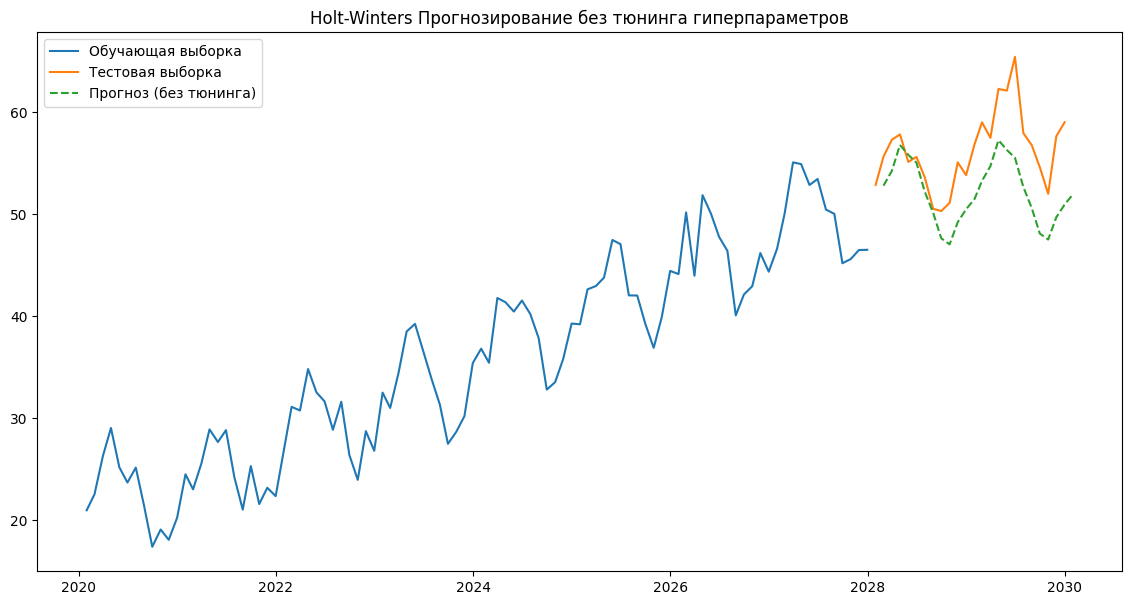


Режим тюнинга (без подбора длины сезона):
Оптимальные параметры:
Alpha: 0.0135
Beta: 0.7414
Gamma: 0.0460
RMSE на тестовой выборке: 2.1261
Прогноз:
2028-02-29    52.823761
2028-03-31    54.822630
2028-04-30    57.839808
2028-05-31    57.226014
2028-06-30    56.884748
2028-07-31    54.547150
2028-08-31    52.855859
2028-09-30    50.710204
2028-10-31    50.435611
2028-11-30    52.831450
2028-12-31    54.397260
2029-01-31    54.852002
2029-02-28    56.928187
2029-03-31    58.927056
2029-04-30    61.944234
2029-05-31    61.330440
2029-06-30    60.989174
2029-07-31    58.651575
2029-08-31    56.960284
2029-09-30    54.814630
2029-10-31    54.540037
2029-11-30    56.935876
2029-12-31    58.501686
2030-01-31    58.956428
Freq: ME, dtype: float64


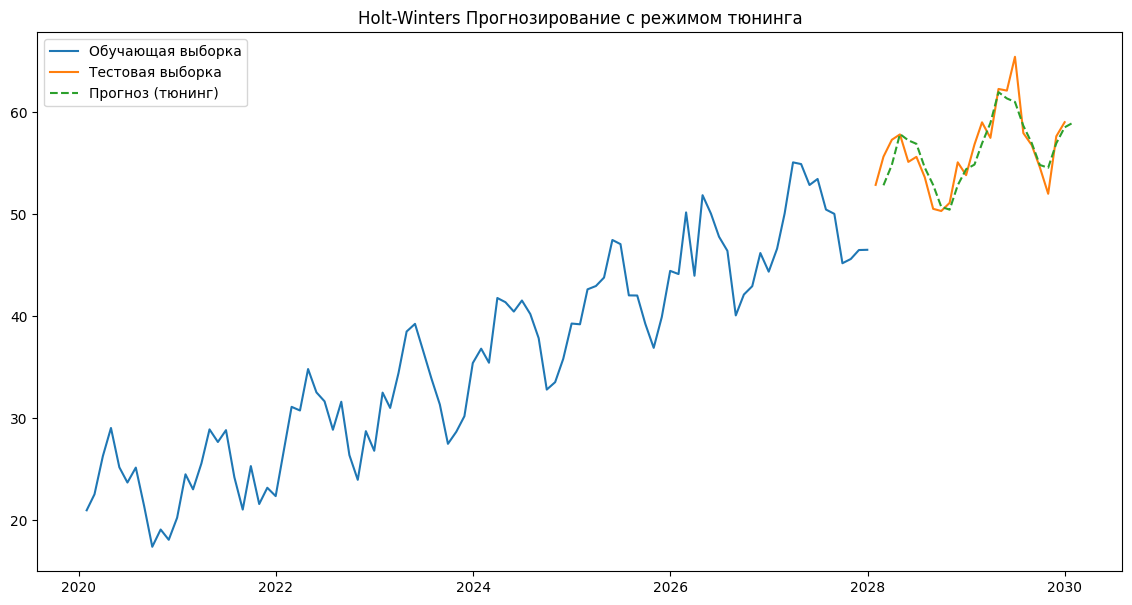


Режим тюнинга (с подбором длины сезона):
Оптимальные параметры:
Alpha: 0.0135
Beta: 0.7414
Gamma: 0.0460
Длина сезона: 12
RMSE на тестовой выборке: 2.1261
Прогноз:
2028-02-29    52.823761
2028-03-31    54.822630
2028-04-30    57.839808
2028-05-31    57.226014
2028-06-30    56.884748
2028-07-31    54.547150
2028-08-31    52.855859
2028-09-30    50.710204
2028-10-31    50.435611
2028-11-30    52.831450
2028-12-31    54.397260
2029-01-31    54.852002
2029-02-28    56.928187
2029-03-31    58.927056
2029-04-30    61.944234
2029-05-31    61.330440
2029-06-30    60.989174
2029-07-31    58.651575
2029-08-31    56.960284
2029-09-30    54.814630
2029-10-31    54.540037
2029-11-30    56.935876
2029-12-31    58.501686
2030-01-31    58.956428
Freq: ME, dtype: float64


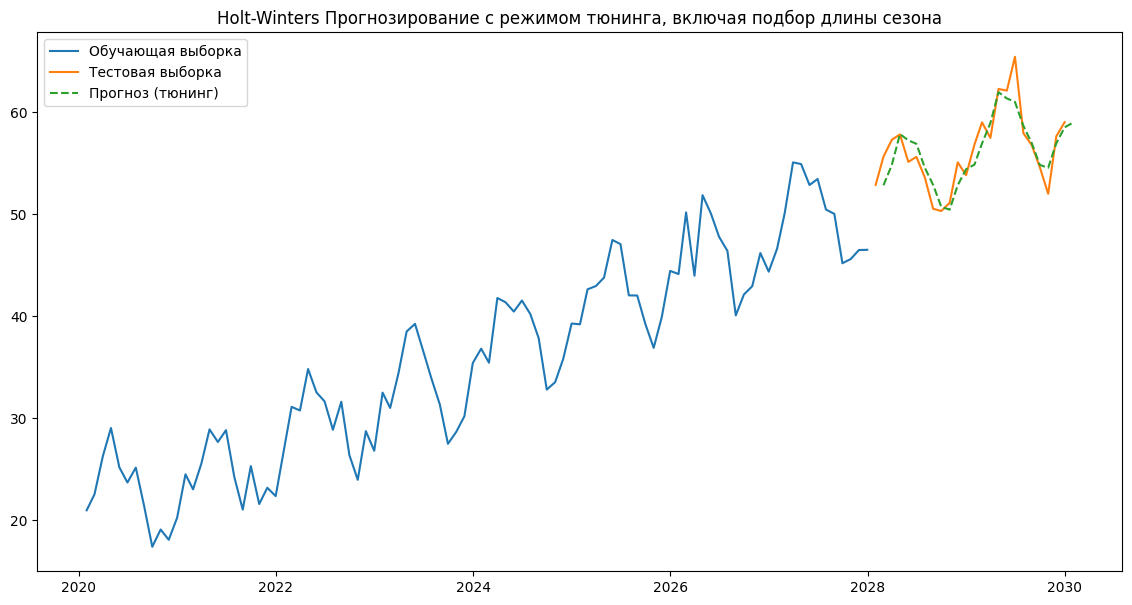

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

class HoltWinters:
    def __init__(self, alpha, beta, gamma, season_length, n_preds):
        """
        Инициализация модели Хольтера-Уинтерса.

        :param alpha: Коэффициент сглаживания уровня (0 < alpha < 1)
        :param beta: Коэффициент сглаживания тренда (0 < beta < 1)
        :param gamma: Коэффициент сглаживания сезонности (0 < gamma < 1)
        :param season_length: Длина сезона (например, 12 для ежемесячных данных)
        :param n_preds: Количество периодов для прогноза вперед
        """
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.season_length = season_length
        self.n_preds = n_preds
        self.level = None
        self.trend = None
        self.season = None
        self.fitted = False

    def initial_trend(self, series):
        sum_trend = 0.0
        for i in range(self.season_length):
            sum_trend += float(series[i + self.season_length] - series[i]) / self.season_length
        return sum_trend / self.season_length

    def initial_seasonal_components(self, series):
        season_averages = []
        n_seasons = int(len(series)/self.season_length)
        for j in range(n_seasons):
            season_avg = np.mean(series[self.season_length*j:self.season_length*j+self.season_length])
            season_averages.append(season_avg)
        seasonal = {}
        for i in range(self.season_length):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += series[self.season_length*j + i] - season_averages[j]
            seasonal[i] = sum_of_vals_over_avg / n_seasons
        return seasonal

    def fit(self, series):
        series = list(series)
        self.level = series[0]
        self.trend = self.initial_trend(series)
        self.season = self.initial_seasonal_components(series)
        self.fitted = True

        for i in range(len(series)):
            if i >= self.season_length:
                season = self.season[i % self.season_length]
                last_level = self.level
                self.level = self.alpha * (series[i] - season) + (1 - self.alpha) * (self.level + self.trend)
                self.trend = self.beta * (self.level - last_level) + (1 - self.beta) * self.trend
                self.season[i % self.season_length] = self.gamma * (series[i] - self.level) + (1 - self.gamma) * season
            else:
                # Для первых m точек используем инициализирующие значения
                self.level = series[i]
                if i > 0:
                    self.trend = self.initial_trend(series)
                if i >= self.season_length:
                    self.season[i % self.season_length] = series[i] - self.level
        return self

    def predict(self):
        if not self.fitted:
            raise Exception("Модель не обучена. Вызовите метод fit().")

        predictions = []
        for i in range(1, self.n_preds + 1):
            seasonal = self.season[i % self.season_length]
            prediction = self.level + i * self.trend + seasonal
            predictions.append(prediction)
        return predictions

    def fit_predict(self, series):
        self.fit(series)
        return self.predict()

# Функция для вычисления RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Функция для оптимизации
def optimize_hw(params, train, test, season_length):
    alpha, beta, gamma = params
    n_preds = len(test)
    hw = HoltWinters(alpha, beta, gamma, season_length, n_preds)
    hw.fit(train)
    predictions = hw.predict()
    error = rmse(test, predictions)
    return error

# Основная функция для прогнозирования и тюнинга
def holt_winters_forecast(series,
                          season_length=None,
                          n_pred_seasons=1,
                          mode='normal',
                          tune_season_length=False,
                          model_params=[0.5, 0.5, 0.5] # alpha, beta, gamma (используется только в режиме 'normal')
                          ):
    """
    Функция для прогнозирования с использованием модели Хольтера-Уинтерса.

    :param series: Входной временной ряд (pandas Series).
    :param season_length: Длина сезона. Если None и не в режиме тюнинга с tune_season_length=True, определяется автоматически.
    :param n_pred_seasons: Количество сезонов для прогнозирования (1 или 2).
    :param mode: 'normal' или 'tuning'.
    :param tune_season_length: Boolean. Если True, длина сезона будет подбираться в режиме тюнинга.
    :param model_params: Параметры модели. Список чисел вида [alpha, beta, gamma]. Используется только в режиме 'normal'.

    :return: В зависимости от режима:
        - 'normal': dict с параметрами модели и прогнозом.
        - 'tuning': dict с параметрами модели, оптимизированными параметрами сглаживания, (длиной сезона, если подбиралась) и прогнозом.
    """
    result = {}
    series = series.copy()

    # Разделение на обучающую и тестовую выборки (80% - обучающая, 20% - тестовая)
    train_size = int(len(series) * 0.8)
    train, test = series[:train_size], series[train_size:]

    n_preds = len(test)

    # Если в режиме тюнинга требуется подобрать длину сезона
    if mode == 'tuning' and tune_season_length:
        # Предположим, что длина сезона может варьироваться от 2 до 24
        possible_seasons = list(range(2, 25))
        best_rmse = float('inf')
        best_params = None
        best_season = None

        for sl in possible_seasons:
            # Оптимизация только для длины сезона, где размер обучающей выборки позволяет
            if train_size < 2 * sl:
                continue
            initial_params = [0.5, 0.5, 0.5]  # Начальные значения для alpha, beta, gamma
            bounds = [(0.01, 0.99), (0.01, 0.99), (0.01, 0.99)]  # Границы для alpha, beta, gamma

            try:
                optimization = minimize(
                    optimize_hw,
                    initial_params,
                    args=(train, test, sl),
                    method='L-BFGS-B',
                    bounds=bounds
                )

                if optimization.fun < best_rmse:
                    best_rmse = optimization.fun
                    best_params = optimization.x
                    best_season = sl
            except:
                continue

        if best_params is not None:
            optimal_alpha, optimal_beta, optimal_gamma = best_params
            result['optimal_alpha'] = optimal_alpha
            result['optimal_beta'] = optimal_beta
            result['optimal_gamma'] = optimal_gamma
            result['season_length'] = best_season
            result['rmse'] = best_rmse
            # Обучение модели с оптимальными параметрами
            hw_opt = HoltWinters(optimal_alpha, optimal_beta, optimal_gamma, best_season, n_preds)
            hw_opt.fit(train)
            predictions = hw_opt.predict()

            # Преобразуем прогнозы в pandas Series с соответствующими датами
            forecast_index = pd.date_range(start=series.index[train_size], periods=n_preds + 1, freq=series.index.freq)[1:]
            forecast = pd.Series(predictions, index=forecast_index)

            result['forecast'] = forecast
        else:
            raise Exception("Не удалось подобрать оптимальные параметры.")

    elif mode == 'tuning' and not tune_season_length:
        # Тюнинг только параметров сглаживания
        initial_params = [0.5, 0.5, 0.5]  # Начальные значения для alpha, beta, gamma
        bounds = [(0.01, 0.99), (0.01, 0.99), (0.01, 0.99)]  # Границы для alpha, beta, gamma

        optimization = minimize(
            optimize_hw,
            initial_params,
            args=(train, test, season_length),
            method='L-BFGS-B',
            bounds=bounds
        )

        optimal_alpha, optimal_beta, optimal_gamma = optimization.x
        result['optimal_alpha'] = optimal_alpha
        result['optimal_beta'] = optimal_beta
        result['optimal_gamma'] = optimal_gamma
        result['rmse'] = optimization.fun

        # Обучение модели с оптимальными параметрами
        hw_opt = HoltWinters(optimal_alpha, optimal_beta, optimal_gamma, season_length, n_preds, model=model)
        hw_opt.fit(train)
        predictions = hw_opt.predict()

        # Преобразуем прогнозы в pandas Series с соответствующими датами
        forecast_index = pd.date_range(start=series.index[train_size], periods=n_preds + 1, freq=series.index.freq)[1:]
        forecast = pd.Series(predictions, index=forecast_index)

        result['forecast'] = forecast
        result['season_length'] = season_length

    elif mode == 'normal':
        # В обычном режиме используем предоставленные параметры
        if season_length is None:
            raise ValueError("season_length должен быть указан в обычном режиме.")

        # Обучение модели с заданными параметрами
        hw = HoltWinters(alpha=model_params[0], beta=model_params[1], gamma=model_params[2], season_length=season_length,
                        n_preds=n_preds)
        hw.fit(train)
        predictions = hw.predict()

        # Преобразуем прогнозы в pandas Series с соответствующими датами
        forecast_index = pd.date_range(start=series.index[train_size], periods=n_preds + 1, freq=series.index.freq)[1:]
        forecast = pd.Series(predictions, index=forecast_index)

        # Заполнение результатов
        result['level'] = hw.level
        result['trend'] = hw.trend
        result['season_last_values'] = {k: v for k, v in hw.season.items()}
        result['forecast'] = forecast

    else:
        raise ValueError("Неверный режим. Выберите 'normal' или 'tuning'.")

    return result

# Создание синтетических данных для проверки модели
np.random.seed(42)
periods = 120
season_length = 12
trend = np.linspace(10, 50, periods)
seasonal = 10 + np.sin(np.arange(periods) * (2 * np.pi / season_length)) * 5
noise = np.random.normal(0, 2, periods)
data = trend + seasonal + noise

# Преобразуем данные в pandas Series с датами
dates = pd.date_range(start='2020-01-01', periods=periods, freq='M')
series = pd.Series(data, index=dates)

# Обычный режим
normal_result = holt_winters_forecast(series,
                                      season_length=12,
                                      n_pred_seasons=1,
                                      mode='normal',
                                      model_params=[0.1, 0.5, 0.1])
print("Обычный режим:")
print("Уровень:", normal_result.get('level'))
print("Тренд:", normal_result.get('trend'))
print("Последние значения сезонности:", normal_result.get('season_last_values'))
print("Прогноз:")
print(normal_result.get('forecast'))

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(series[:int(len(series)*0.8)], label='Обучающая выборка')
plt.plot(series[int(len(series)*0.8):], label='Тестовая выборка')
plt.plot(normal_result['forecast'], label='Прогноз (без тюнинга)', linestyle='--')
plt.legend()
plt.title('Holt-Winters Прогнозирование без тюнинга гиперпараметров')
plt.show()

# Режим тюнинга без подбора длины сезона
tuning_result = holt_winters_forecast(series,
                                      season_length=12,
                                      n_pred_seasons=1,
                                      mode='tuning',
                                      tune_season_length=False)
print("\nРежим тюнинга (без подбора длины сезона):")
print(f"Оптимальные параметры:")
print(f"Alpha: {tuning_result.get('optimal_alpha'):.4f}")
print(f"Beta: {tuning_result.get('optimal_beta'):.4f}")
print(f"Gamma: {tuning_result.get('optimal_gamma'):.4f}")
print(f"RMSE на тестовой выборке: {tuning_result.get('rmse'):.4f}")
print("Прогноз:")
print(tuning_result.get('forecast'))

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(series[:int(len(series)*0.8)], label='Обучающая выборка')
plt.plot(series[int(len(series)*0.8):], label='Тестовая выборка')
plt.plot(tuning_result['forecast'], label='Прогноз (тюнинг)', linestyle='--')
plt.legend()
plt.title('Holt-Winters Прогнозирование с режимом тюнинга')
plt.show()

# Режим тюнинга с подбором длины сезона
tuning_season_result = holt_winters_forecast(series,
                                            mode='tuning',
                                            tune_season_length=True)
print("\nРежим тюнинга (с подбором длины сезона):")
print(f"Оптимальные параметры:")
print(f"Alpha: {tuning_season_result.get('optimal_alpha'):.4f}")
print(f"Beta: {tuning_season_result.get('optimal_beta'):.4f}")
print(f"Gamma: {tuning_season_result.get('optimal_gamma'):.4f}")
print(f"Длина сезона: {tuning_season_result.get('season_length')}")
print(f"RMSE на тестовой выборке: {tuning_season_result.get('rmse'):.4f}")
print("Прогноз:")
print(tuning_season_result.get('forecast'))

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(series[:int(len(series)*0.8)], label='Обучающая выборка')
plt.plot(series[int(len(series)*0.8):], label='Тестовая выборка')
plt.plot(tuning_season_result['forecast'], label='Прогноз (тюнинг)', linestyle='--')
plt.legend()
plt.title('Holt-Winters Прогнозирование с режимом тюнинга, включая подбор длины сезона')
plt.show()

Обычный режим:
Уровень: 51341.580064229136
Тренд: 1167.717868498847
Последние значения сезонности: {0: 147.55556609022022, 1: 334.2568332024676, 2: 1420.5583986554134, 3: 1069.9162669860389, 4: -427.940349700276, 5: -687.0960645933953, 6: -4451.8968724613715, 7: -5175.434541766111, 8: -3630.2510607334407, 9: -1580.3447410443594, 10: 809.010173876765, 11: 12665.753962672688}
Прогноз:
2019-09-30     52843.554766
2019-10-31     55097.574200
2019-11-30     55914.649937
2019-12-31     55584.511189
2020-01-31     56493.073342
                  ...      
2024-06-30    119878.226611
2024-07-31    132902.688268
2024-08-31    121552.207740
2024-09-30    122906.626876
2024-10-31    125160.646310
Freq: ME, Length: 62, dtype: float64


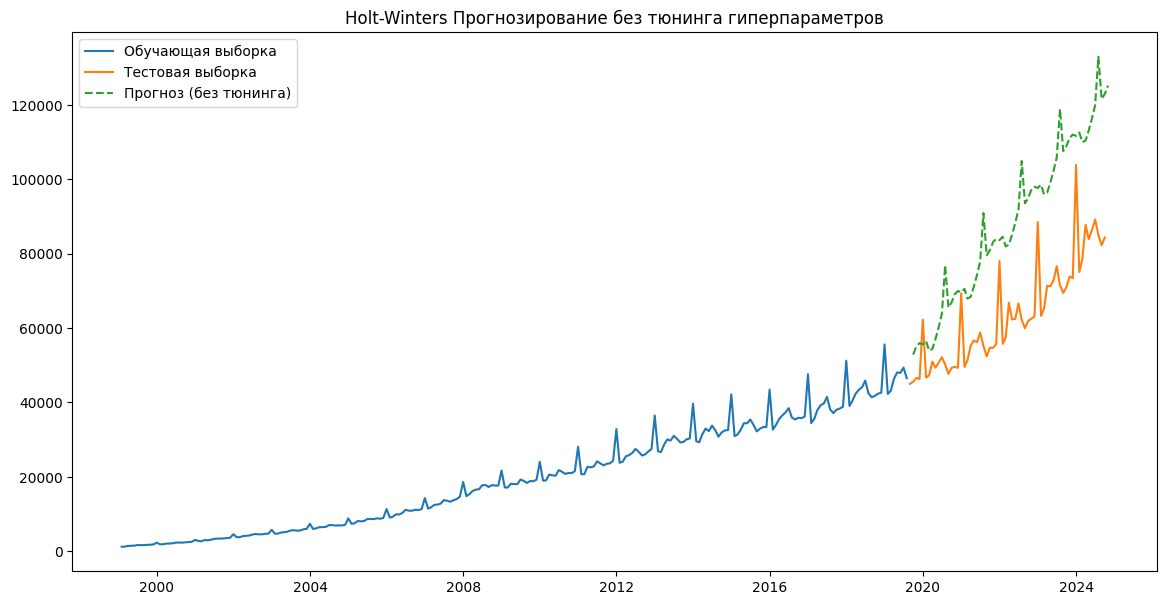


Режим тюнинга (без подбора длины сезона):
Оптимальные параметры:
Alpha: 0.0100
Beta: 0.7499
Gamma: 0.0100
RMSE на тестовой выборке: 6418.9527
Прогноз:
2019-09-30    44069.117474
2019-10-31    45767.356979
2019-11-30    46758.083216
2019-12-31    47475.612260
2020-01-31    48989.224280
                  ...     
2024-06-30    80003.024466
2024-07-31    86359.514187
2024-08-31    79112.139453
2024-09-30    79956.154644
2024-10-31    81654.394149
Freq: ME, Length: 62, dtype: float64


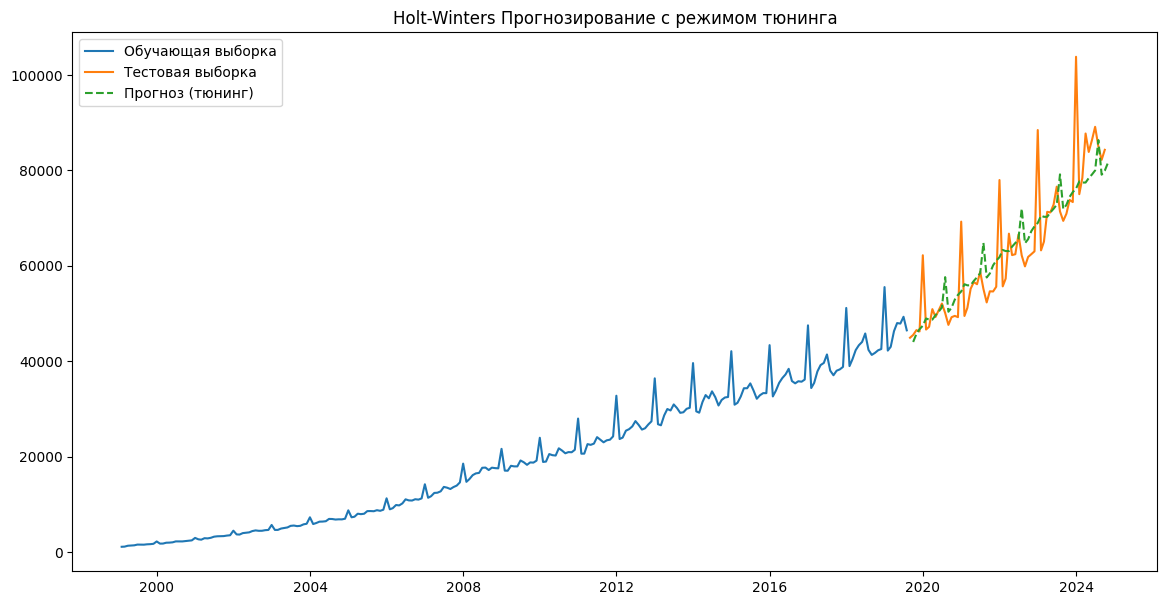


Режим тюнинга (с подбором длины сезона):
Оптимальные параметры:
Alpha: 0.5813
Beta: 0.9900
Gamma: 0.4303
Длина сезона: 6
RMSE на тестовой выборке: 5077.5549
Прогноз:
2019-09-30    41372.934765
2019-10-31    42639.504813
2019-11-30    44510.069211
2019-12-31    46936.038014
2020-01-31    54864.540359
                  ...     
2024-06-30    80975.783141
2024-07-31    88904.285486
2024-08-31    81897.583965
2024-09-30    79194.873794
2024-10-31    80461.443843
Freq: ME, Length: 62, dtype: float64


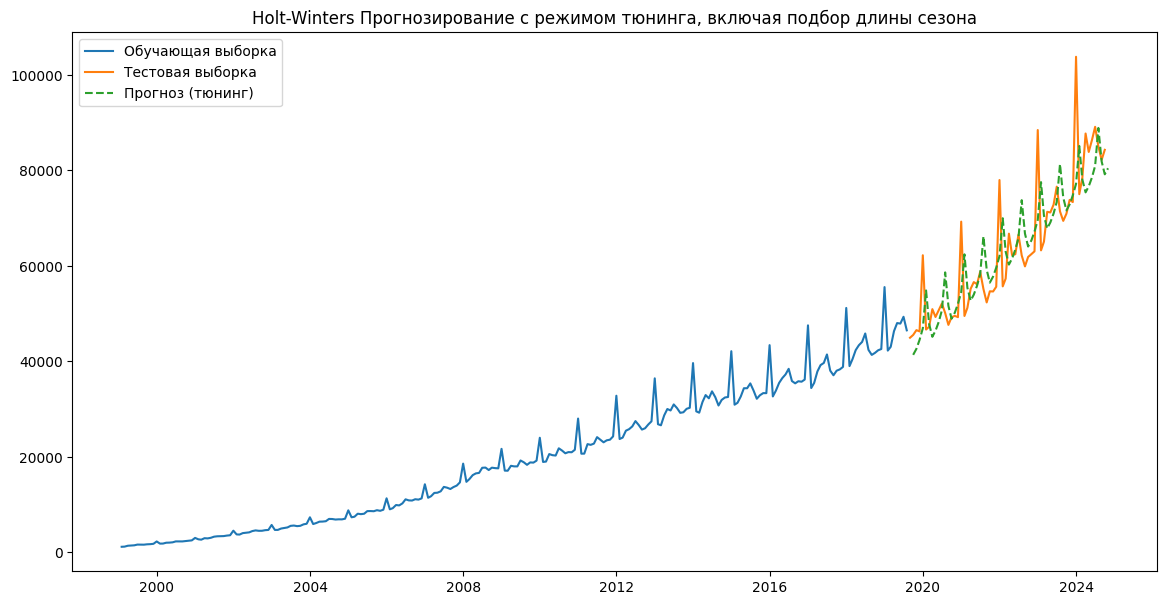

In [50]:
# Применение алгоритма на данных среднемесячной номинальной начисленной заработной платы работников по полному кругу организаций
# в целом по экономике Российской Федерации в 1999-2024гг. по данным Росстата (источник - https://rosstat.gov.ru/labor_market_employment_salaries)
data = pd.read_csv("sample_data/TS.csv")

# Данные импортированы в формате excel, поэтому удобнее восстановить временные метки в коде
dates = pd.date_range(start='1999-01-01', periods=309, freq='M')
series = pd.Series(data['Data'].values, index=dates)

# Обычный режим
normal_result = holt_winters_forecast(series,
                                      season_length=12,
                                      n_pred_seasons=1,
                                      mode='normal',
                                      model_params=[0.5, 0.9, 0.4])
print("Обычный режим:")
print("Уровень:", normal_result.get('level'))
print("Тренд:", normal_result.get('trend'))
print("Последние значения сезонности:", normal_result.get('season_last_values'))
print("Прогноз:")
print(normal_result.get('forecast'))

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(series[:int(len(series)*0.8)], label='Обучающая выборка')
plt.plot(series[int(len(series)*0.8):], label='Тестовая выборка')
plt.plot(normal_result['forecast'], label='Прогноз (без тюнинга)', linestyle='--')
plt.legend()
plt.title('Holt-Winters Прогнозирование без тюнинга гиперпараметров')
plt.show()

# Режим тюнинга без подбора длины сезона
tuning_result = holt_winters_forecast(series,
                                      season_length=12,
                                      n_pred_seasons=1,
                                      mode='tuning',
                                      tune_season_length=False)
print("\nРежим тюнинга (без подбора длины сезона):")
print(f"Оптимальные параметры:")
print(f"Alpha: {tuning_result.get('optimal_alpha'):.4f}")
print(f"Beta: {tuning_result.get('optimal_beta'):.4f}")
print(f"Gamma: {tuning_result.get('optimal_gamma'):.4f}")
print(f"RMSE на тестовой выборке: {tuning_result.get('rmse'):.4f}")
print("Прогноз:")
print(tuning_result.get('forecast'))

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(series[:int(len(series)*0.8)], label='Обучающая выборка')
plt.plot(series[int(len(series)*0.8):], label='Тестовая выборка')
plt.plot(tuning_result['forecast'], label='Прогноз (тюнинг)', linestyle='--')
plt.legend()
plt.title('Holt-Winters Прогнозирование с режимом тюнинга')
plt.show()

# Режим тюнинга с подбором длины сезона
tuning_season_result = holt_winters_forecast(series,
                                            mode='tuning',
                                            tune_season_length=True)
print("\nРежим тюнинга (с подбором длины сезона):")
print(f"Оптимальные параметры:")
print(f"Alpha: {tuning_season_result.get('optimal_alpha'):.4f}")
print(f"Beta: {tuning_season_result.get('optimal_beta'):.4f}")
print(f"Gamma: {tuning_season_result.get('optimal_gamma'):.4f}")
print(f"Длина сезона: {tuning_season_result.get('season_length')}")
print(f"RMSE на тестовой выборке: {tuning_season_result.get('rmse'):.4f}")
print("Прогноз:")
print(tuning_season_result.get('forecast'))

# Визуализация результатов
plt.figure(figsize=(14, 7))
plt.plot(series[:int(len(series)*0.8)], label='Обучающая выборка')
plt.plot(series[int(len(series)*0.8):], label='Тестовая выборка')
plt.plot(tuning_season_result['forecast'], label='Прогноз (тюнинг)', linestyle='--')
plt.legend()
plt.title('Holt-Winters Прогнозирование с режимом тюнинга, включая подбор длины сезона')
plt.show()